In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.vq import whiten
import time 
import scipy as sp

from sklearn.decomposition import FastICA, PCA
from IPython.core.display import HTML, display

# play functions in iPython notebook
try:
    from IPython.display import Audio
    def wavPlayer(data, rate=8192):
        display(Audio(data, rate=rate))
except ImportError:
    pass

# 7.2 ) Natural Gradient Infomax vs FastICA

In [2]:
def readData(filename):
    print("Reading %s" % filename)
    return np.fromfile(filename, dtype=float, sep='\n')
#     return ds
s1 = readData('sounds/sound1.dat')
s2 = readData('sounds/sound2.dat')

Reading sounds/sound1.dat
Reading sounds/sound2.dat


In [4]:
wavPlayer(s2)

In [7]:
S = np.stack((s1,s2))

In [248]:
A = np.random.random((2,2))
A_inv = np.linalg.inv(A)

In [249]:
X = np.dot(A, S)

In [250]:
def correlate(x,s):
    dim = x.shape[0]
    corr = np.zeros((dim,dim))
    for i in range(dim):
        for j in range(i,dim):
            c = np.corrcoef(x[i,:], s[j,:])[0,1]
            corr[i,j] = c
            corr[j,i] = corr[i,j]
    return corr

In [251]:
correlate(X,S)

array([[ 0.20059709,  0.97992588],
       [ 0.97992588,  0.9552357 ]])

In [252]:
wavPlayer(X[0,:])
wavPlayer(X[1,:])

In [253]:
X_centered = X - np.mean(X, axis=1).reshape(2,1)

In [254]:
np.allclose([0,0], np.mean(X_centered, axis=1))

True

In [255]:
X_centered_shuffled = np.random.permutation(X_centered.T).T

In [256]:
wavPlayer(X_centered_shuffled[0,:])

In [257]:
correlate(X_centered_shuffled, S)

array([[ 0.00993772,  0.01143695],
       [ 0.01143695,  0.01202783]])

In [258]:
W = np.array([[1,2],[3,4]]) # todo initialize randomly

In [259]:
def plotExperiment(x, s_est, s_original,  dataset=""):
    total = x.shape[1]
    x_range = np.array(range(total))
    
    plt.figure(figsize=(10,10))
    
    for i in range(x.shape[0]):
        plt.subplot(5,2,i+1)
        plt.plot(x_range, x[i,:].T)
        plt.title('%s : Mixed signal %d' % (dataset, i+1) )
        plt.xticks([])
        plt.yticks([])

    for i in range(x.shape[0]):
        plt.subplot(5,2,2+ i+1)
        plt.plot(x_range, s_est[i,:].T)
        plt.title('%s %d ' % ('De-mixed signal', i+1) )
        plt.xticks([])
        plt.yticks([])
        
    for i in range(x.shape[0]):
        plt.subplot(5,2, 4+ i+1)
        plt.plot(x_range, s_original[i,:].T)
        plt.title('%s %d' % ('Original signal', i+1) )
        plt.xticks([])
        plt.yticks([])

## Recover sources from Natural Gradient

Natural Gradient took 0.734022s.
Correlation before reconstruction
[[ 0.20059709  0.97992588]
 [ 0.97992588  0.9552357 ]]
Correlation after reconstruction
[[ 0.99997906 -0.00521089]
 [-0.00521089  0.99608383]]


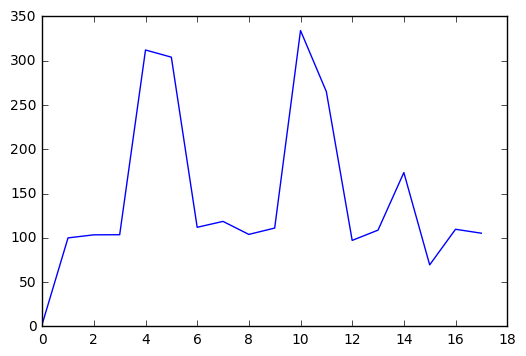

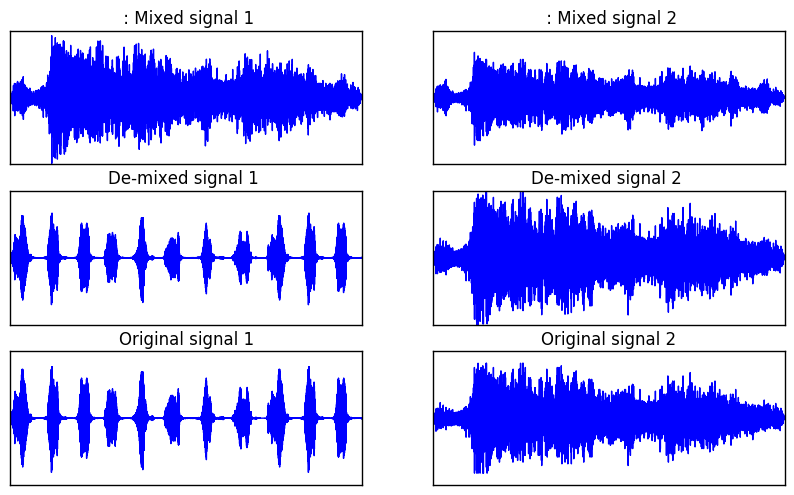

In [260]:
def natural_gradient(w,x, eta=0.01, lambda_=0.9999):
    derec_delta = np.eye(x.shape[0])
    norms = []
    ww = np.copy(w)
    for i in range(x.shape[1]):

        x_i = np.matrix(x[:,i]).T
        wx = np.matmul(w, x_i)
        f_wx = 1 - 2*sp.special.expit(wx)
        gradient = w + np.dot(np.matmul(f_wx, x_i.T), np.dot(w.T,w) )
#         gradient= w + np.dot( np.matmul(f_wx.reshape(2,1),x_i.reshape(1,2)),np.dot(ww.T,ww) )
        
        w = w + eta* gradient
        eta = eta*lambda_
        if i % 1000 == 0:
            norms.append(np.linalg.norm(gradient))
            pass
    return w, norms
        
start_time = time.time()
W_natural_grad, norms = natural_gradient(np.matrix(W), X_centered_shuffled, eta=0.01)
print("Natural Gradient took %fs."% (time.time() - start_time))
print("Correlation before reconstruction")
print(correlate(X_centered, S))
S_recovered_nat = np.matmul(W_natural_grad, X_centered)
print("Correlation after reconstruction")
print(correlate(S_recovered_nat, S))
plt.plot(norms)
plotExperiment(X_centered, S_recovered_nat, S)

## Recover sources from FastICA

FastICA took 0.010990 seconds
Correlation before reconstruction
[[ 0.20059709  0.97992588]
 [ 0.97992588  0.9552357 ]]
Correlation between sources and unmixed signals using FastICA
[[ 0.99999688 -0.00123688]
 [-0.00123688  0.99999924]]


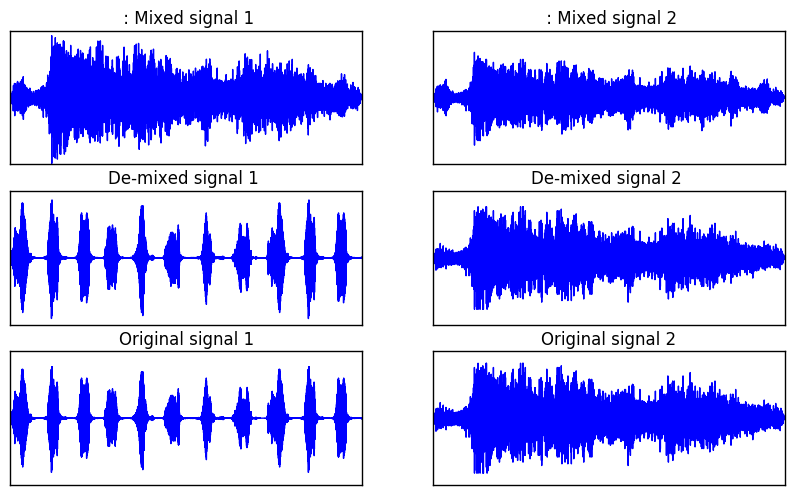

In [292]:
start_time = time.time()
fastICA = FastICA(n_components=2, whiten=True)

fastICA.fit_transform(X_centered_shuffled.T)
S_recovered_fastica = np.dot(fastICA.components_, X_centered)
print("FastICA took %f seconds" %  ( time.time() - start_time ))
print("Correlation before reconstruction")
print(correlate(X_centered, S))
print("Correlation between sources and unmixed signals using FastICA")
print(correlate(S_recovered_fastica, S))
plotExperiment(X_centered, S_recovered_fastica, S) 

In [293]:
np.linalg.norm(fastICA.components_ - A_inv)

48.334229260845277

In [294]:
np.linalg.norm(W_natural_grad - A_inv)

58.126216952419945

FastICA is faster than Natural Gradient and has better the quality. This claim can be examined by comparing the distance between $W$ learnt from the algorithms and $A^{-1}$,
\begin{align*}
|| W_{\text{FastICA}} - A^{-1} || < || W_{\text{NatGrad}} - A^{-1} ||
\end{align*}

# 7.3 ) ICA on Image Patches

In [266]:
import matplotlib.image as mpimg
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

In [273]:
# b1 = mpimg.imread('./imgpca/b%d.jpg'%(1))

def loadImageMatrix(cat, n=10, patch_size=(16,16), patches_per_img=2000):
    print("Loading %d %dx%d patches from '%s' category" % ( patches_per_img * n, patch_size[0], patch_size[1], cat ))
    total_cols = patch_size[0]*patch_size[1]
    matrix = np.zeros((n*patches_per_img, total_cols))
    for i in range(n):
        img = mpimg.imread('./imgpca/%s%d.jpg'%(cat, i+1))
        str_idx = i*patches_per_img
        patches = extract_patches_2d(img, patch_size=patch_size, max_patches = patches_per_img )
        matrix[ str_idx:str_idx+patches_per_img, : ] = patches.reshape(patches_per_img, total_cols )

    return matrix

matrix_building = loadImageMatrix('b')
matrix_nature  = loadImageMatrix('n')
matrix_text  = loadImageMatrix('t')

Loading 20000 16x16 patches from 'b' category
Loading 20000 16x16 patches from 'n' category
Loading 20000 16x16 patches from 't' category


In [319]:
matrix_building.shape

(20000, 256)

In [324]:
def plotPCs(components, cmap="gray", vmin=None, vmax=None):
    plt.figure(figsize=(10,2))
    for i in range(2):
        for j in range(10):
            idx = i*10+j
            plt.subplot(2,10,idx+1)
            plt.imshow(components[:, idx].reshape(16,16), cmap=cmap, vmin=vmin, vmax=vmax)
            plt.title( "%d-PC" %(idx+1))
            plt.xticks([])
            plt.yticks([])
    plt.tight_layout()

In [276]:
ica_b = FastICA(n_components=256,whiten=True) # logcosh and a = 1 is the default function
ica_building = ica_b.fit(matrix_building)

In [323]:
pca_b = PCA(n_components=256,whiten=True)
pca_building = pca_b.fit(matrix_building)

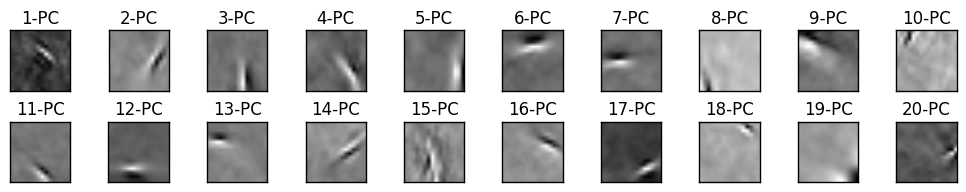

In [325]:
plotPCs(ica_building.mixing_)

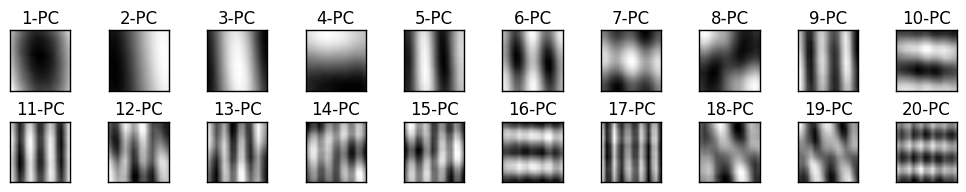

In [326]:
plotPCs(pca_building.components_.T)

In [311]:
ica_n = FastICA(n_components=256,whiten=True) # logcosh and a = 1 is the default function
ica_nature = ica_n.fit(matrix_nature)

/opt/conda/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [327]:
pca_n = PCA(n_components=256,whiten=True)
pca_nature = pca_b.fit(matrix_nature)

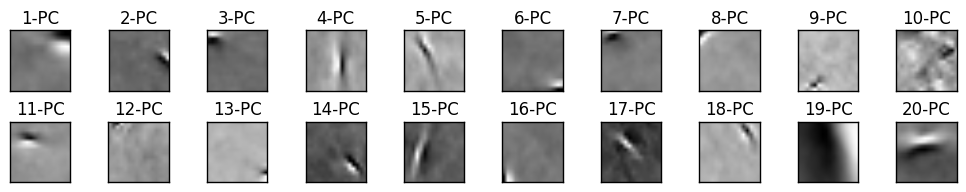

In [312]:
plotPCs(ica_nature.mixing_)

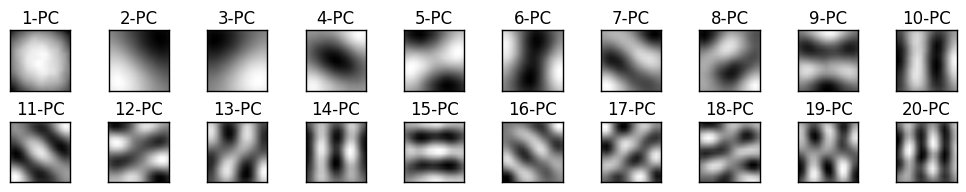

In [328]:
plotPCs(pca_nature.components_.T)

In [333]:
ica_t = FastICA(n_components=256,whiten=True) # logcosh and a = 1 is the default function
ica_text = ica_t.fit(matrix_text)

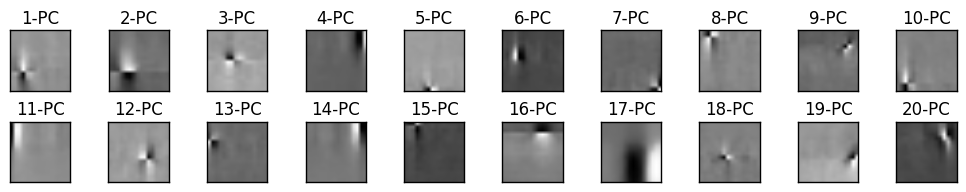

In [334]:
plotPCs(ica_text.mixing_)

In [331]:
pca_t = PCA(n_components=256,whiten=True)
pca_text = pca_t.fit(matrix_text)

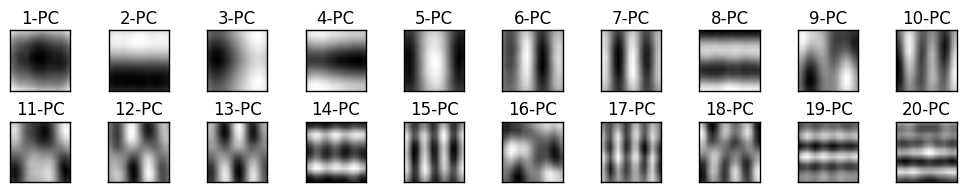

In [332]:
plotPCs(pca_text.components_.T)